In [1]:
import numpy as np
import glob
import os
import re
from pprint import pprint

# Load data

In [2]:
images = np.load('data/hand_dataset/images.npy')
labels = np.load('data/hand_dataset/labels.npy')

print('images', images.shape, images.dtype)
print('labels', labels.shape, labels.dtype)

images (3443, 250, 250, 3) float32
labels (3443, 4) float64


In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
import cv2

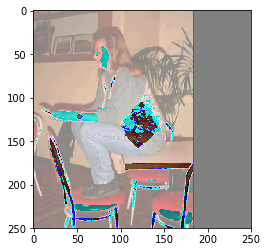

In [4]:
plt.imshow(images[1234])
plt.show()

# Shuffle train dataset

In [5]:
from sklearn.utils import shuffle

In [6]:
train_data, train_labels = shuffle(images, labels)

test_data = train_data[0:30]
test_labels = train_labels[0:30]

train_data = train_data[30:]
train_labels = train_labels[30:]

In [7]:
import keras.backend.tensorflow_backend as K
from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv2D, Dropout
from keras.layers.normalization import BatchNormalization
from keras.optimizers import adam
from keras.utils.data_utils import Sequence

K_CONFIG = K.tf.ConfigProto()
K_CONFIG.allow_soft_placement = True
K_CONFIG.gpu_options.allow_growth = True
K.set_session(K.tf.Session(config=K_CONFIG))

Using TensorFlow backend.


In [54]:
activation = 'relu'

def model(dshape):
    seq_model = Sequential()

    # seq_model.add(BatchNormalization(axis=0, input_shape=(dshape[0], dshape[1], dshape[2])))
    seq_model.add(Conv2D(24, (10, 10), padding='valid',
                  activation=activation, strides=(2, 2),
                  input_shape=(dshape[0], dshape[1], dshape[2])))
    seq_model.add(Conv2D(36, (10, 10), padding='valid', activation=activation, strides=(2, 2)))
    seq_model.add(Dropout(0.4))
    seq_model.add(Conv2D(48, (10, 10), padding='valid', activation=activation, strides=(2, 2)))
    seq_model.add(Dropout(0.4))
    seq_model.add(Conv2D(64, (8, 8), padding='valid', activation=activation))
    seq_model.add(Dropout(0.4))
    seq_model.add(Conv2D(48, (6, 6), padding='valid', activation=activation))
    seq_model.add(Dropout(0.4))
    seq_model.add(Conv2D(36, (6, 6), padding='valid', activation=activation))
    seq_model.add(Dropout(0.3))
    seq_model.add(Conv2D(16, (4, 4), padding='valid', activation=activation))
    seq_model.add(Conv2D(4, (4, 4), padding='valid', activation=activation))
    seq_model.add(Flatten())
    # seq_model.add(Dense(4))
    # seq_model.add(Dense(4))
    seq_model.compile(loss='mse', optimizer=adam(0.0003))
    seq_model.summary()

    return seq_model

In [55]:
keras_model = model((train_data.shape[1], train_data.shape[2], 3))  # creates model

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_98 (Conv2D)           (None, 121, 121, 24)      7224      
_________________________________________________________________
conv2d_99 (Conv2D)           (None, 56, 56, 36)        86436     
_________________________________________________________________
dropout_69 (Dropout)         (None, 56, 56, 36)        0         
_________________________________________________________________
conv2d_100 (Conv2D)          (None, 24, 24, 48)        172848    
_________________________________________________________________
dropout_70 (Dropout)         (None, 24, 24, 48)        0         
_________________________________________________________________
conv2d_101 (Conv2D)          (None, 17, 17, 64)        196672    
_________________________________________________________________
dropout_71 (Dropout)         (None, 17, 17, 64)        0         
__________

In [56]:
from keras.callbacks import ModelCheckpoint

In [57]:
chk_callback = ModelCheckpoint(
    filepath='model/weights/no_class_weight_{epoch:03d}_{val_loss:.3f}_{loss:.3f}.h5',
    verbose=1,
    save_best_only=False,
    save_weights_only=False,
    mode='auto',
    period=40
)

callbacks = [chk_callback]

In [58]:
keras_model.fit(train_data, train_labels, epochs=30, batch_size=64,
                shuffle=True, validation_split=0.05, verbose=1,
                # class_weight=class_weight_dict,
                callbacks=callbacks
               )

Train on 3242 samples, validate on 171 samples
Epoch 1/30
3242/3242 [==============================] - 5s - loss: 0.0926 - val_loss: 0.0726
Epoch 2/30
3242/3242 [==============================] - 5s - loss: 0.0677 - val_loss: 0.0719
Epoch 3/30
3242/3242 [==============================] - 5s - loss: 0.0664 - val_loss: 0.0691
Epoch 4/30
3242/3242 [==============================] - 5s - loss: 0.0658 - val_loss: 0.0692
Epoch 5/30
3242/3242 [==============================] - 5s - loss: 0.0652 - val_loss: 0.0687
Epoch 6/30
3242/3242 [==============================] - 5s - loss: 0.0650 - val_loss: 0.0682
Epoch 7/30
3242/3242 [==============================] - 5s - loss: 0.0649 - val_loss: 0.0684
Epoch 8/30
3242/3242 [==============================] - 5s - loss: 0.0649 - val_loss: 0.0697
Epoch 9/30
3242/3242 [==============================] - 5s - loss: 0.0649 - val_loss: 0.0684
Epoch 10/30
3242/3242 [==============================] - 5s - loss: 0.0646 - val_loss: 0.0680
Epoch 11/30
3242/3242 

# Test model

In [61]:
def get_hand(img, coords, plot=False):
    hand_h = 26
    hand_w = 18
    
    hand = img[coords[1] - hand_h//2: coords[1] + hand_h//2,
               coords[0] - hand_w//2: coords[0] + hand_w//2]
    
    # print(hand.shape)
    
    if hand.shape[0] != hand_h or hand.shape[1] != hand_w:
        return None
    
    plt.imshow(hand)
    plt.show()

[ 0.     0.     0.524  0.388]


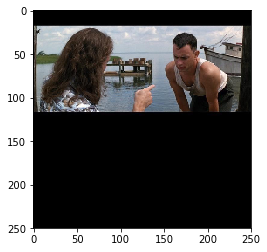

[ 0.21271178  0.23240486  0.15939884  0.28239399]
LABEL / PRED


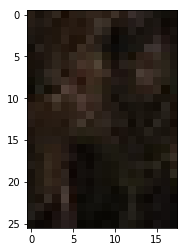

LABEL / PRED


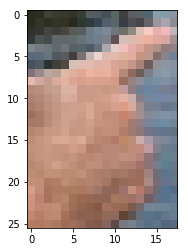

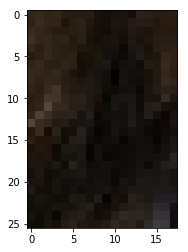

In [64]:
test_nr = 6
test_im = np.array(test_data[test_nr] * 255 + 127.5, np.uint8)

print(test_labels[test_nr])
plt.imshow(test_im)
plt.show()

pred = keras_model.predict(images[test_nr:test_nr + 1])[0]
print(pred)

print('LABEL / PRED')
get_hand(test_im, [int(test_labels[test_nr][0] * test_im.shape[1]),
                   int(test_labels[test_nr][1] * test_im.shape[0])], plot=True)
get_hand(test_im, [int(pred[0] * test_im.shape[1]),
                   int(pred[1] * test_im.shape[0])], plot=True)

print('LABEL / PRED')
get_hand(test_im, [int(test_labels[test_nr][2] * test_im.shape[1]),
                   int(test_labels[test_nr][3] * test_im.shape[0])], plot=True)
get_hand(test_im, [int(pred[2] * test_im.shape[1]),
                   int(pred[3] * test_im.shape[0])], plot=True)

# Save Model

In [82]:
def save_keras_model(save_model, path):
    """Save keras model to given path."""
    save_model.save_weights(path + 'model.h5')

    with open(path + 'model.json', "w") as text_file:
        text_file.write(save_model.to_json())

    print('Keras json model saved.', path + 'model.json')
    print('Keras h5 model saved.', path + 'model.h5')

In [83]:
save_path = "model/"
save_keras_model(keras_model, save_path)

Keras json model saved. model/model.json
Keras h5 model saved. model/model.h5


# Test Inference

In [17]:
from model.Inference import GenreClassifier
import logging

logging.basicConfig(format='%(asctime)s %(levelname)s %(message)s',
                    datefmt='%m/%d/%Y %H:%M:%S',
                    level=logging.DEBUG)

In [18]:
weight_path = '/home/nauris/Dropbox/coding/squalio/nytonn/model/weights/no_class_weight_249_1.095_0.362.h5'
CLASSIFICATOR = GenreClassifier(weight_path)

In [20]:
print(train_file_names[1])
preds, preds_sorted = CLASSIFICATOR.get_classification(fingerprint=test_data[1])

print()
for pred_sorted in preds_sorted:
    print(pred_sorted)

11/08/2017 21:56:10 DEBUG Genre prediction for (20, 64, 300, 1) fingerprint
11/08/2017 21:56:10 INFO {0: 'alternativerock', 1: 'blueeyedsoul', 2: 'bluesrock', 3: 'breakbeatpop', 4: 'britpop', 5: 'classical', 6: 'contemporaryrb', 7: 'dancepop', 8: 'dancepunk', 9: 'dancerock', 10: 'disco', 11: 'drumbass', 12: 'experimentalrock', 13: 'folkrock', 14: 'funk', 15: 'hardrock', 16: 'hiphop', 17: 'house', 18: 'indiepop', 19: 'jazz', 20: 'poprock', 21: 'punkrock', 22: 'reggae', 23: 'rockroll', 24: 'singersongwriter', 25: 'soul', 26: 'speech', 27: 'techno', 28: 'triphop'}


/home/nauris/Dropbox/coding/squalio/nytonn/fingerprints/crop_audio/fp_008/classical_7ad078eaf4087b4f37e641cbb99a8f6c_10.mp3

('dancepop', 0.30106246285861049)
('britpop', 0.12894556662371282)
('dancerock', 0.10248279506013205)
('disco', 0.095654022177056694)
('poprock', 0.094239404166270913)
('indiepop', 0.072415481791540504)
('punkrock', 0.052790338327781676)
('bluesrock', 0.024299809176235941)
('alternativerock', 0.019884241225736329)
('hiphop', 0.015259652326275529)
('house', 0.01461782449323901)
('breakbeatpop', 0.012657364541623818)
('techno', 0.011008598129683534)
('hardrock', 0.010951986688263467)
('dancepunk', 0.010399217856652501)
('singersongwriter', 0.0050617721697093108)
('contemporaryrb', 0.0043211073668105553)
('blueeyedsoul', 0.0042274786844089746)
('reggae', 0.0034676717045173909)
('drumbass', 0.0034269276171631671)
('folkrock', 0.0033587286546479713)
('experimentalrock', 0.0022213506483927696)
('jazz', 0.0017472845736557828)
('funk', 0.0016825840644706601)
('rockroll',

In [21]:
test_dir = '/home/nauris/Dropbox/coding/squalio/nytonn/test_samples/'
test_sample = 'hop1.mp3'

preds, preds_sorted = CLASSIFICATOR.get_classification(audio_file=test_dir + test_sample)

print()
for pred_sorted in preds_sorted:
    print(pred_sorted)

11/08/2017 21:56:42 INFO Predicting genre for /home/nauris/Dropbox/coding/squalio/nytonn/test_samples/hop1.mp3
11/08/2017 21:56:44 DEBUG audio: (5308758,), sampling_rate: 22050
11/08/2017 21:56:44 DEBUG dtype: float32, Min: -1.000031, Mean: -0.000717, Max: 1.000000
11/08/2017 21:56:44 INFO FFmpeg loaded /home/nauris/Dropbox/coding/squalio/nytonn/test_samples/hop1.mp3
11/08/2017 21:56:44 INFO 
11/08/2017 21:56:44 INFO 
11/08/2017 21:56:44 INFO FFmpeg Results 1 (1, 5308758) float32 (5308758,) float32
11/08/2017 21:56:44 DEBUG Input samples (1, 5308758) --> (5308758,)
11/08/2017 21:56:44 DEBUG STFT: (513, 20738) --> amp_block_reduce: (103, 20738) --> amps_crop: (12, 64, 300)
11/08/2017 21:56:44 INFO Fingerprints [12] created: /home/nauris/Dropbox/coding/squalio/nytonn/test_samples/hop1.mp3
11/08/2017 21:56:44 INFO Fingerprints created. Shape: (12, 64, 300)
11/08/2017 21:56:44 DEBUG Fingerprint (12, 64, 300)
11/08/2017 21:56:44 INFO {0: 'alternativerock', 1: 'blueeyedsoul', 2: 'bluesrock',


('hiphop', 0.79695203628701461)
('contemporaryrb', 0.19861369186401132)
('dancepop', 0.002409147129886454)
('reggae', 0.00094329829207965069)
('dancerock', 0.00033040688897519505)
('triphop', 0.00016164897507220388)
('blueeyedsoul', 0.00014799600290984086)
('drumbass', 9.021211311144161e-05)
('indiepop', 8.1585669534511789e-05)
('speech', 5.9455058673515041e-05)
('house', 4.4253191566812074e-05)
('soul', 4.2292362483991798e-05)
('breakbeatpop', 3.2914307759204538e-05)
('funk', 2.3368007838129909e-05)
('alternativerock', 2.0883560028680154e-05)
('poprock', 1.3318243755916503e-05)
('hardrock', 1.0372902420008325e-05)
('singersongwriter', 9.8265082063693303e-06)
('disco', 5.9508847594605517e-06)
('rockroll', 2.4589861007553336e-06)
('punkrock', 1.6811738522669781e-06)
('jazz', 1.073734665717066e-06)
('bluesrock', 1.0309236982511789e-06)
('dancepunk', 6.3772750203613493e-07)
('techno', 3.5901313246876557e-07)
('classical', 5.6448507606438919e-08)
('folkrock', 1.9020221292569903e-08)
('bri